In [1]:
%%capture
!pip install transformers sentence_transformers seaborn umap-learn

In [2]:
%%capture
!pip3 install pickle5

## Loading the models

In [3]:
labels = ['Macroeconomía','Regulaciones','Innovación','Alianza','Sostenibilidad','Descartable']

In [4]:
SIMILARITY_TRAINED = True

from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
model_name = 'hiiamsid/sentence_similarity_spanish_es'

tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
from sentence_transformers import InputExample

if SIMILARITY_TRAINED:
  model = SentenceTransformer(model_name)
else:
  model = AutoModel.from_pretrained(model_name)




Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/770 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

## Loading the triples from the pickle

In [6]:
import pickle5 as pickle

with open('../input/fewshotdataton/few_shot_pairs_train_no_duplicates.pickle', 'rb') as f:
    pickle_obj = pickle.load(f)

In [7]:
train_examples = [] 

for pair in pickle_obj['pairs']: 
    train_examples.append(InputExample(texts=[pair['anchor'], pair['positive'], pair['negative']]))

                                              
sizes = {}
category_sentences = [] 

for label in labels: 
    sizes[label] = len([pair for pair in pickle_obj['pairs'] if pair['label'] == label])
#     category_sentences.append([pair['anchor'] for pair in pickle_obj['pairs'] if pair['label'] == label])

category_sentences = [pair['anchor'] for pair in pickle_obj['pairs']]

In [8]:
sizes

{'Macroeconomía': 96,
 'Regulaciones': 51,
 'Innovación': 96,
 'Alianza': 51,
 'Sostenibilidad': 18,
 'Descartable': 51}

In [9]:
sizes[labels[0]]

96

I built this dictionary to ease the color mapping in the plot. We are out colours and we still have one more category that we need to fit ('Other'). We should consider finding another way to map colours or to find a plotting library which is richer in colours

In [10]:
colors_markers = {
    'Macroeconomía': 'r', 
    'Regulaciones': 'b', 
    'Innovación': 'g',
    'Alianza': 'm',
    'Sostenibilidad': 'y', 
    'Reputación': 'cyan',
    'Descartable': 'k'
}

In [11]:
test_sentences = []
test_labels = []


with open('../input/fewshotdataton/few_shot_pairs_test_sentences.pickle', 'rb') as f:
    pickle_obj_test = pickle.load(f)
    test_sentences = [sentence for sentence,label in pickle_obj_test['test_pairs']]
    test_labels = [label for sentence, label in pickle_obj_test['test_pairs']]


In [12]:
test_labels

['Macroeconomía',
 'Reputación',
 'Regulaciones',
 'Alianza',
 'Descartable',
 'Reputación',
 'Alianza',
 'Macroeconomía',
 'Reputación']

## Generating the embeddings

In [13]:
import torch
import numpy as np
import itertools
# texts = list(itertools.chain(*category_sentences))
texts = category_sentences + test_sentences
# len_test_sentences = len(list(itertools.chain(*test_sentences)))
# print(texts)
if SIMILARITY_TRAINED:
  embeddings = model.encode(texts)
else:
  tokens = tokenizer(texts)
  max_len = max([len(i) for i in tokens['input_ids']])
  tokens_input_ids_padded = [list(token_input_id) + [tokenizer.pad_token_id]*(max_len-len(token_input_id)) for token_input_id in tokens['input_ids']]
  attention_masks_padded = [list(attention_mask) + [0]*(max_len-len(attention_mask)) for attention_mask in tokens['attention_mask']]
  embeddings = model(torch.tensor(tokens_input_ids_padded, dtype=torch.long, device=torch.device('cpu')), \
                     attention_mask=torch.tensor(attention_masks_padded, dtype=torch.long, device=torch.device('cpu'))).last_hidden_state[:,0,:].detach().numpy()




Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
import umap
reducer = umap.UMAP()
embed_2d = reducer.fit_transform(embeddings)
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
len(embed_2d[:, 0])

372

## Plotting the embeddings based on each label

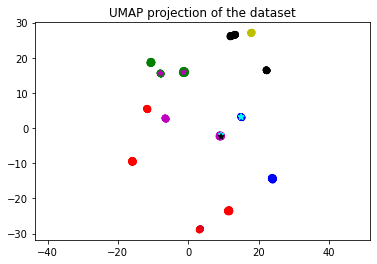

In [16]:
plt.scatter(
    embed_2d[:len(category_sentences), 0],
    embed_2d[:len(category_sentences), 1],
    c = [colors_markers[pair['label']] for pair in pickle_obj['pairs']],
    marker='o')
plt.scatter(
    embed_2d[len(category_sentences):, 0],
    embed_2d[len(category_sentences):, 1],
    c = [colors_markers[label] for label in test_labels],
    marker='*')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset');

## TripletLoss

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)
from sentence_transformers import losses
train_loss = losses.TripletLoss(model=model)
num_epochs = 15
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [18]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          optimizer_params={'lr': 5e-05}) 

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

Iteration:   0%|          | 0/182 [00:00<?, ?it/s]

In [19]:
import torch
import numpy as np
import itertools
# texts = list(itertools.chain(*category_sentences))
texts = category_sentences + test_sentences
# len_test_sentences = len(list(itertools.chain(*test_sentences)))

if SIMILARITY_TRAINED:
  embeddings = model.encode(texts)
  
else:
  tokens = tokenizer(texts)
  max_len = max([len(i) for i in tokens['input_ids']])
  tokens_input_ids_padded = [list(token_input_id) + [tokenizer.pad_token_id]*(max_len-len(token_input_id)) for token_input_id in tokens['input_ids']]
  attention_masks_padded = [list(attention_mask) + [0]*(max_len-len(attention_mask)) for attention_mask in tokens['attention_mask']]
  embeddings = model(torch.tensor(tokens_input_ids_padded, dtype=torch.long, device=torch.device('cpu')), \
                     attention_mask=torch.tensor(attention_masks_padded, dtype=torch.long, device=torch.device('cpu'))).last_hidden_state[:,0,:].detach().numpy()




Batches:   0%|          | 0/12 [00:00<?, ?it/s]

## TripletLoss cluster plotting

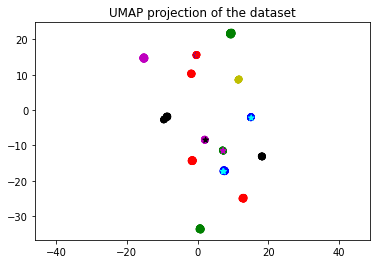

In [20]:
import umap
reducer = umap.UMAP()
embed_2d = reducer.fit_transform(embeddings)
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embed_2d[:len(category_sentences), 0],
    embed_2d[:len(category_sentences), 1],
    c = [colors_markers[pair['label']] for pair in pickle_obj['pairs']],
    marker='o')
plt.scatter(
    embed_2d[len(category_sentences):, 0],
    embed_2d[len(category_sentences):, 1],
    c = [colors_markers[label] for label in test_labels],
    marker='*')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset');